# Clustering countries based on thei HCPI_M

- features are extracted from the hcpi data

- uses k-means, hdbscan or hierarchical clustering

- the clusters are saved into `data/clusters.json`

**Revise:**

- the number of clusters might need to be adjusted

- might try to use a different set of features

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import json

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

# Read & Treat the Data

In [11]:
hcpi = pd.read_parquet("data/hcpi_m.parquet")

data = hcpi.loc["2010-01":"2023-12"].dropna(axis=1)
print(data.shape)
data.head(3)

(168, 163)


,AFG,AGO,ALB,ARE,ARM,ATG,AUT,AZE,BDI,BEL,...,UKR,URY,USA,UZB,VCT,VNM,WSM,XKX,ZAF,ZMB
2010-01-01,73.652677,18.297409,82.400000,88.008742,97.670572,86.417242,89.04379,97.2,59.651634,90.72124,...,93.3,36.150900,88.8,29.722643,100.0,58.542273,90.343792,87.955386,75.30460,105.0
2010-02-01,72.992480,18.459746,83.600000,87.859764,97.571898,86.617995,89.20885,98.3,59.619112,91.10775,...,95.1,36.353887,89.0,30.026943,100.1,59.689701,91.718191,88.191825,75.77624,105.5
2010-03-01,72.924208,18.654168,83.691822,87.943564,98.220672,86.596486,90.19913,99.6,60.055027,91.44471,...,95.9,36.698583,89.4,30.283906,100.2,60.137374,92.084697,88.113012,76.40508,106.6


Normalize the data

In [12]:
def normalize(series, mean=None, std=None):
    series = np.log1p(series)
    if mean is None:
        mean = np.mean(series)
        std = np.std(series)
    return (series - mean) / std, mean, std

def denormalize(norm_series, mean, std):
    return np.expm1(norm_series * std + mean)

countries_metadata = {}
for i, row in data.T.iterrows():
    country = row.name
    series = row.values
    series = pd.Series(series, index=data.index)

    # get metadata about the series
    _, mean, std = normalize(series)

    countries_metadata[country] = {
        "mean": mean,
        "std": std,
    }

# apply the normalization to the entire dataset
data_norm = data.apply(
    lambda x: normalize(x, countries_metadata[x.name]["mean"], countries_metadata[x.name]["std"])[0]
)

Extract country features

In [13]:
def extract_features(series):
    skewness = skew(series)
    slope = np.polyfit(np.arange(len(series)), series, 1)[0]

    try:
        stl = STL(series, period=12, robust=True)
        res = stl.fit()
        seasonal_strength = np.var(res.seasonal) / np.var(series)
    except:
        seasonal_strength = np.nan

    return pd.Series({
        "skew": skewness,
        "trend_slope": slope,
        "seasonal_strength": seasonal_strength
    })

features_df = data_norm.apply(extract_features, axis=0).T
features_df.isna().sum()

skew                 0
trend_slope          0
seasonal_strength    0
dtype: int64

Normalize the features

In [14]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)

# Clustering countries based on their HCPI distribution

## Correlation matrix

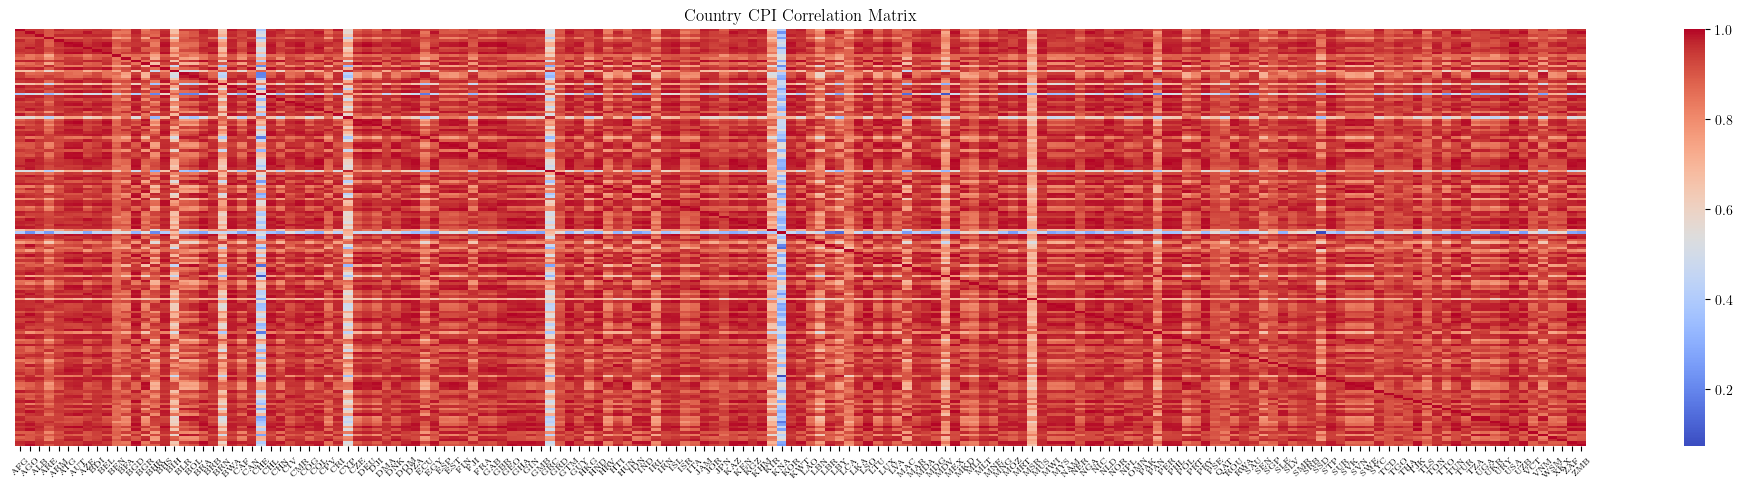

In [15]:
plt.figure(figsize=(20, 5))
sns.heatmap(data_norm.corr(), cmap='coolwarm', cbar=True, xticklabels=True, yticklabels=False)
plt.xticks(fontsize=6, rotation=45)
plt.title('Country CPI Correlation Matrix ')
plt.tight_layout()
plt.show()

## Clustering

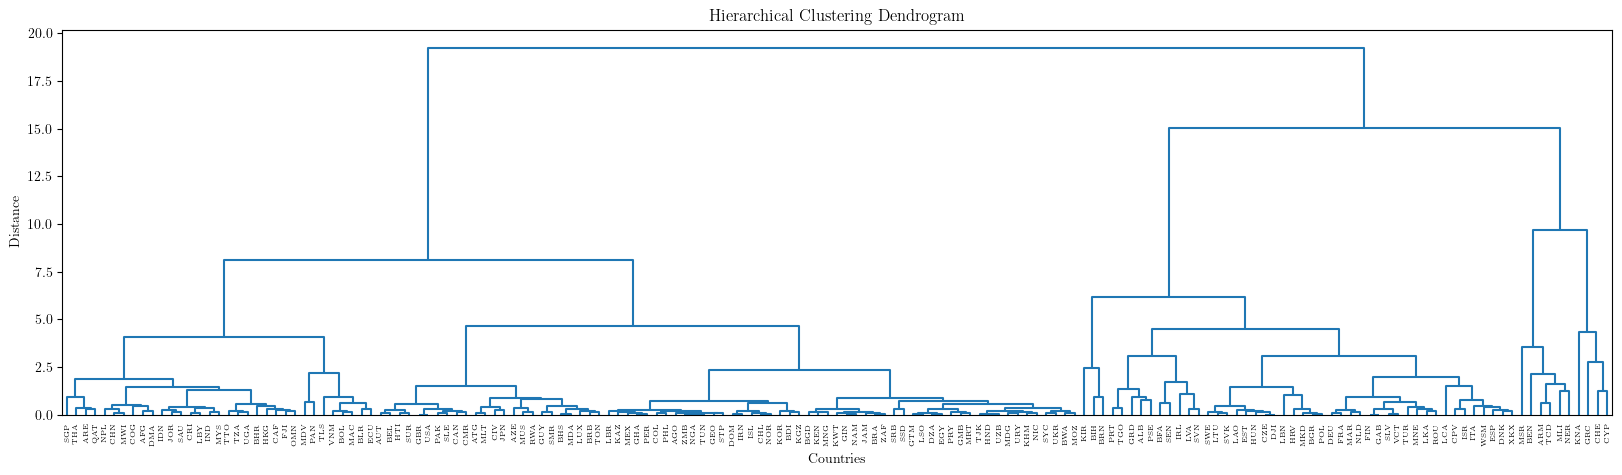

In [16]:
# KMeans
#from sklearn.cluster import KMeans
#kmeans = KMeans(n_clusters=5, random_state=0)
#labels = kmeans.fit_predict(scaled_features)

# HBSCAN
#from hdbscan import HDBSCAN # more robust than KMeans to noise (e.g.: "single countries")
#clusterer = HDBSCAN(min_cluster_size=5, metric="euclidean")
#labels = clusterer.fit_predict(scaled_features)

# Hierarchical
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
Z = linkage(scaled_features, method='ward') # ward, complete, average
plt.figure(figsize=(20, 5))
dendrogram(Z, labels=features_df.index.astype(str), color_threshold=0)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Countries')
plt.ylabel('Distance')
plt.show()
labels = fcluster(Z, t=11, criterion='maxclust')

features_df["cluster"] = labels

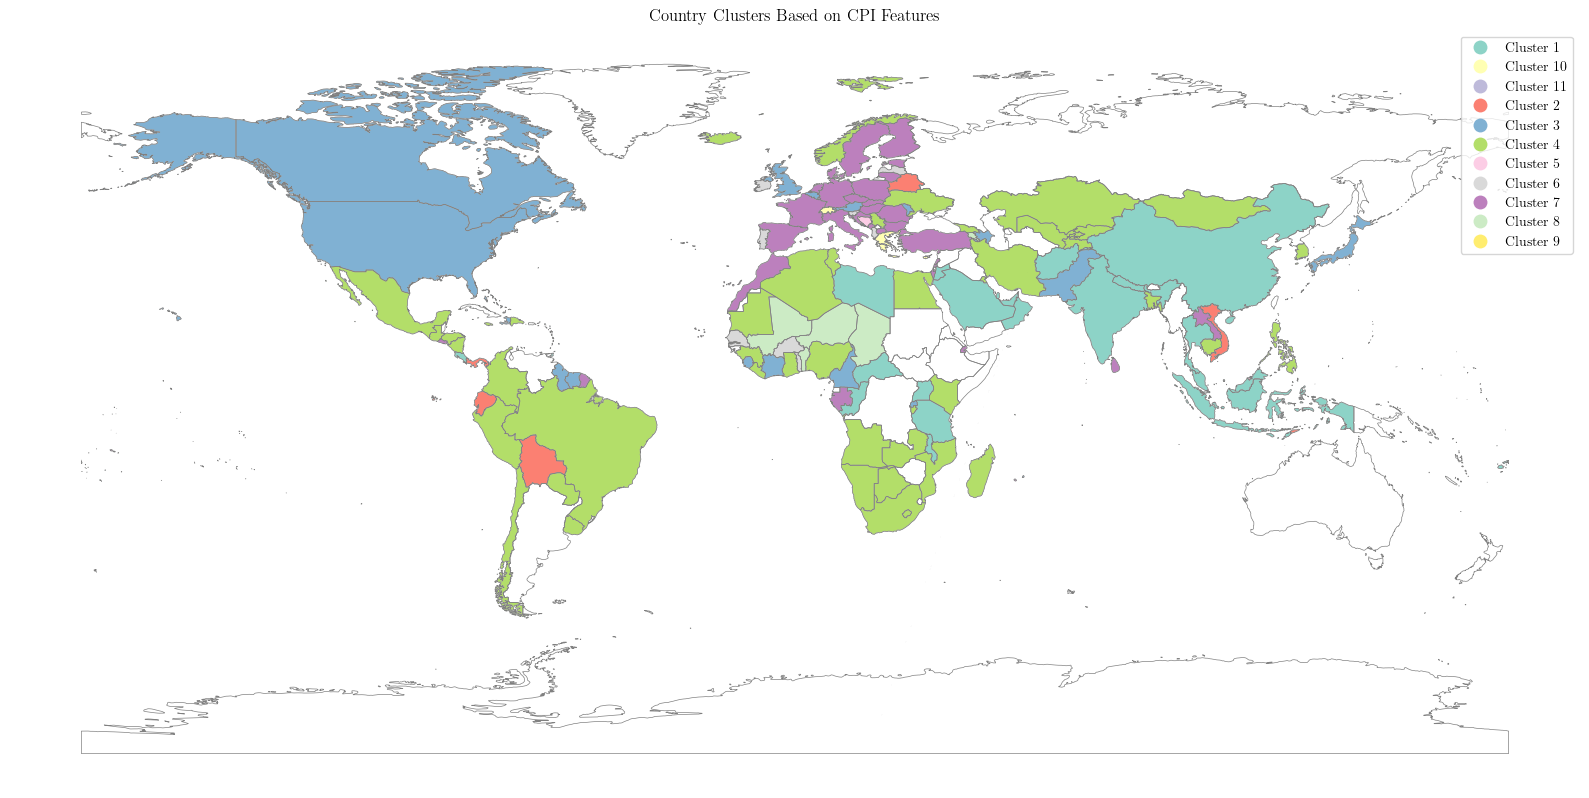

Countries with cluster but missing geometry: {'PSE', 'SSD', 'XKX'}


In [17]:
# merge the cluster labels with the world map
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip")
world = world.merge(
    features_df[["cluster"]]
        .assign(cluster_map=lambda df: df["cluster"].map(
            lambda x: f"Cluster {int(x)}" if not pd.isna(x) else np.nan)),
    left_on="ADM0_A3", right_index=True, how="left"
)

# plot the clusters on the world map
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
world.boundary.plot(ax=ax, linewidth=0.5, color='gray')
world.plot(
    column="cluster_map", 
    cmap="Set3", 
    linewidth=0.5, 
    ax=ax, 
    edgecolor='0.8', 
    legend=True,
)
plt.title("Country Clusters Based on CPI Features")
plt.axis('off')
plt.tight_layout()
plt.show()

# check for countries with missing geometry
all_countries = set(features_df.index)
matched_countries = set(world.dropna(subset=["cluster"])["ADM0_A3"])
print("Countries with cluster but missing geometry:", all_countries - matched_countries)

## Save the clusters

In [18]:
clusters = {}
for i, row in features_df.iterrows():
    cluster = int(row["cluster"])
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(i)

if False:
    with open("data/clusters.json", "w") as f:
        json.dump(clusters, f, indent=4)

if True:
    with open("data/clusters.json", "r") as f:
        clusters = json.load(f)

clusters.keys()

dict_keys(['1', '4', '6', '8', '3', '7', '5', '2', '10', '11', '9'])